In [1]:
#Cambios con respecto a SimulationTest4.1.ipynb: Se intenta añadir que haya rutas de dos robots diferentes que se puedan interseccionar
#No se consigue (era sólo una demo)

In [2]:
# Import general
import pandas as pd
import numpy as np
import array

# Import para mapa
from matplotlib import pyplot
from matplotlib import colors
import pickle

#Import para generar ruta
import heapq
import matplotlib.pyplot as plt

# Import para clases
from abc import ABC

# Import para comprobar ruta
import copy

# Import para generar pedido
import random

# Import para Recopilar datos
from pathlib import Path

In [3]:
# Clases

class Robot(ABC):
    def __init__(self, ID: int, vel: float, pedidos: int, ruta):
        self._ID = ID  # ID del robot
        self._vel: float = vel  # Velocidad del robot
        self._pos = 0  # Posición en matriz array, es un vector
        self._pedidos: int = pedidos  # Número de pedidos máximos del robot
        self._ruta = ruta  # Array de Arrays
        self._vol = 0.0  # Volumen máximo de capacidad
        self._pesomax = 0.0  # Peso máximo de capacidad

        self._proceso: int = 0  # Proceso que se encuentra el robot
        # 0: espera, 1: movimiento, 2: entrega

        self._dist: float = 0.0  # Distancia recorrida por el robot
        self._inter: int = 0  # Intersecciones entre robots encontradas
        self._tiempoespera: float = 0.0  # Tiempo del robot esperando

    def get_ID(self) -> int:
        return self._ID

    def set_ID(self, ID: int):
        self._ID = ID

    def get_vel(self) -> float:
        return self._vel

    def set_vel(self, vel: float):
        if vel > 0:
            self._vel = vel

    def get_pos(self):
        return self._pos

    def set_pos(self, pos):
        self._pos = pos

    def get_pedidos(self) -> int:
        return self._pedidos

    def set_pedidos(self, pedidos: int):
        if pedidos == 6 or pedidos == 12:
            self._pedidos = pedidos

    def get_vol(self) -> float:
        return self._vol

    def set_vol(self, vol: float):
        if vol > 0:
            self._vol = vol

    def get_pesomax(self) -> float:
        return self._pesomax

    def set_pesomax(self, pesomax: float):
        if pesomax > 0:
            self._pesomax = pesomax 

    def get_proceso(self) -> int:
        return self._proceso

    def set_proceso(self, proceso: int):
        if proceso >= 0 and proceso <= 3:
            self._proceso = proceso

    def get_ruta(self) -> array.array:
        return self._ruta

    def set_ruta(self, ruta: array.array):
        self._ruta = ruta

    def get_dist(self) -> float:
        return self._dist

    def set_dist(self, dist: float):
        if dist > 0:
            self._dist = dist

    def get_inter(self) -> int:
        return self._inter

    def set_inter(self, inter: int):
        if inter > 0:
            self._inter = inter

    def get_tiempoespera(self) -> float:
        return self._tiempoespera

    def set_tiempoespera(self, tiempoespera: float):
        if tiempoespera > 0:
            self._tiempoespera = tiempoespera


class Humano(ABC):
    def __init__(self, ID: int, vel: float, picktime: float):
        self._ID = ID  # ID del humano
        self._pos: float = 0.0  # Posición del humano en matriz
        self._vel: float = 0.0  # Velocidad del humano
        self._picktime: float = 15.0  # Tiempo que tarda en hacer el pick

        self._proceso: int = 0  # Proceso en el que está el humano
        # 0: parado, 1: pedido, 3: picking, 4: regreso

        self._modo: str = "espera"  # Modo en el que está

    def get_ID(self) -> int:
        return self._ID

    def set_ID(self, ID: int):
        self._ID = ID

    def get_vel(self) -> float:
        return self._vel

    def set_vel(self, vel: float):
        if vel > 0:
            self._vel = vel

    def get_pos(self):
        return self._pos

    def set_pos(self, pos):
        self._pos = pos

    def get_picktime(self) -> float:
        return self._picktime

    def set_picktime(self, picktime: float):
        if picktime > 0:
            self._picktime = picktime

    def get_proceso(self) -> int:
        return self._proceso

    def set_proceso(self, proceso: int):
        if proceso >= 0 and proceso <= 4:
            self._proceso = proceso

    def get_modo(self) -> str:
        return self._modo

    def set_modo(self, modo: str):
        self._modo = modo

    


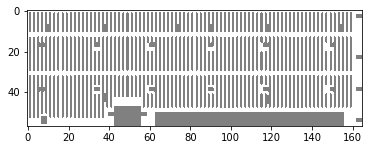

In [4]:
# Mapa Layout SPF

map_SPF = np.ones((57, 165), dtype=int)

for i in range(map_SPF.shape[1]):
    if (i % 2) == 0:
        map_SPF[:, i] = 0

map_SPF[0, :] = 0  # Fila 0 vacia
map_SPF[11:13, :] = 0  # Fila gruesa vacia
map_SPF[30:32, :] = 0  # Fila gruesa vacia
map_SPF[:, 160:165] = 0  # Columna gruesa final vacia
map_SPF[53:57, 0:38] = 0  # Zona inferior izquierda vacia
map_SPF[48:57, 38:42] = 0  #
map_SPF[43:47, 42:57] = 0  #
map_SPF[47:57, 43:55] = 1  # Hueco ocupado "exterior"
map_SPF[48:57, 56:63] = 0  #
map_SPF[48:50, 63:156] = 0  # Filas que separan la zona de recogida vacias
map_SPF[48:57, 156:164] = 0  #
map_SPF[50:57, 63:156] = 1  # Zona de recogida ocupada
map_SPF[51, 7:10] = 0  # Hueco encima de una escalera
# Huecos intercalados:
map_SPF[16:20, 32:37] = 0  # Hueco a
map_SPF[16:20, 58:63] = 0  # Hueco b
map_SPF[16:20, 88:93] = 0  # Hueco e
map_SPF[16:20, 114:119] = 0  # Hueco g
map_SPF[16:20, 146:151] = 0  # Hueco i
map_SPF[37:41, 32:37] = 0  # Hueco d
map_SPF[37:41, 58:63] = 0  # Hueco c
map_SPF[37:41, 88:93] = 0  # Hueco f
map_SPF[37:41, 114:119] = 0  # Hueco h
map_SPF[37:41, 146:151] = 0  # Hueco j
# Escaleras:
map_SPF[7:11, 10:12] = 1  #
map_SPF[7:11, 38:40] = 1  #
map_SPF[7:11, 74:76] = 1  #
map_SPF[7:11, 90:92] = 1  #
map_SPF[7:11, 118:120] = 1  #
map_SPF[7:11, 154:156] = 1  #
map_SPF[52:56, 7:10] = 1  #
map_SPF[41:45, 38:40] = 1  #
map_SPF[42:46, 118] = 1  #
# Cuadrados azules derecha:
map_SPF[2:4, 162:165] = 1  #
map_SPF[22:24, 162:165] = 1  #
map_SPF[38:40, 162:165] = 1  #
map_SPF[53:55, 162:165] = 1  #
# Cuadrados azules abajo:
map_SPF[50:52, 40:43] = 1  #
map_SPF[50:52, 56:59] = 1  #
# Columnas verdes:
map_SPF[16:18, 6:9] = 1  #
map_SPF[16:18, 33:36] = 1  #
map_SPF[16:18, 60:63] = 1  #
map_SPF[16:18, 89:92] = 1  #
map_SPF[16:18, 116:119] = 1  #
map_SPF[16:18, 149:152] = 1  #
map_SPF[38:40, 6:9] = 1  #
map_SPF[38:40, 33:36] = 1  #
map_SPF[38:40, 60:63] = 1  #
map_SPF[38:40, 89:92] = 1  #
map_SPF[38:40, 116:119] = 1  #
map_SPF[38:40, 149:152] = 1  #


list_SPF = map_SPF.tolist()


# Escritura en modo binario, vacía el fichero si existe
fichero = open("mapaTarancon_P1.pckl", "wb")

# Escribe la colección en el fichero
pickle.dump(list_SPF, fichero)

fichero.close()

"""
# Lectura en modo binario
fichero = open("mapaTarancon_P1.pckl", "rb")

# Cargamos los datos del fichero
lista_fichero = pickle.load(fichero)

fichero.close()
"""

colormap = colors.ListedColormap(["white", "grey"])
# entregando este problema a
pyplot.imshow(list_SPF, cmap=colormap)
pyplot.show()

In [5]:
# Función Generar Pedido

def generar_pedido():

    y = 0

    # y es el valor que establece si el vector es correcto o no 
    # 0: incorrecto, 1: Correcto

    while y == 0:

        num1 = random.randint(1, 55) # Valor random del eje x
        num2 = random.randint(1, 158) # Valor random del eje y

        x = 0 
        
        """x es el número de "0" que hay en las 9 posiciones contiguas a la
        selección. Si hay 4 o menos "0", la selección será válida
        (ya que no está en los pasillos). Si hay más de 4 "0" significa que
        está en un pasillo u otro espacio en el que no hay estantería"""

        # Comprueba las 9 casillas contiguas en las que hay "0"

        if map_SPF[num1 + 1, num2] == 0:
            x = x + 1

        if map_SPF[num1 + 1, num2 + 1] == 0:
            x = x + 1

        if map_SPF[num1, num2 + 1] == 0:
            x = x + 1

        if map_SPF[num1 - 1, num2 + 1] == 0:
            x = x + 1

        if map_SPF[num1 - 1, num2] == 0:
            x = x + 1

        if map_SPF[num1 - 1, num2 - 1] == 0:
            x = x + 1

        if map_SPF[num1, num2 - 1] == 0:
            x = x + 1

        # Comprueba que la posición está libre y hay 4 o menos casillas con "0"
        if x <= 4 and map_SPF[num1, num2] == 0:
            y = 1
            vector = np.array([num1, num2])

        # Caso en el que la selección no es válida
        if x > 4 or map_SPF[num1, num2] == 1:
            y = 0

    return num1, num2

In [6]:
# heuristic function for path scoring

#https://www.analytics-link.com/post/2018/09/14/applying-the-a-path-finding-algorithm-in-python-part-1-2d-square-grid
 
def heuristic(a, b):

    return np.sqrt((b[0] - a[0]) ** 2 + (b[1] - a[1]) ** 2)
 
# path finding function
 
def astar(array, start, goal):
    neighbors = [(0,1),(0,-1),(1,0),(-1,0),(1,1),(1,-1),(-1,1),(-1,-1)]
    #(1,1),(-1,1),(1,-1),(-1,-1) Quitamos movimientos diagonales
    close_set = set()

    came_from = {}
    gscore = {start:0}
    fscore = {start:heuristic(start, goal)}

    oheap = []
    heapq.heappush(oheap, (fscore[start], start))

    while oheap:
        current = heapq.heappop(oheap)[1]
        if current == goal:
            data = []

            while current in came_from:

                data.append(current)
                current = came_from[current]
            data = data + [start]
            data = data[::-1]
            return data
        close_set.add(current)

        for i, j in neighbors:

            neighbor = current[0] + i, current[1] + j
            tentative_g_score = gscore[current] + heuristic(current, neighbor)

            if 0 <= neighbor[0] < array.shape[0]:

                if 0 <= neighbor[1] < array.shape[1]:                

                    if array[neighbor[0]][neighbor[1]] == 1:
                        continue

                else:

                    # array bound y walls
                    continue

            else:

                # array bound x walls
                continue

            if neighbor in close_set and tentative_g_score >= gscore.get(neighbor, 0):

                continue

            if  tentative_g_score < gscore.get(neighbor, 0) or neighbor not in [i[1]for i in oheap]:

                came_from[neighbor] = current
                gscore[neighbor] = tentative_g_score
                fscore[neighbor] = tentative_g_score + heuristic(neighbor, goal)
                heapq.heappush(oheap, (fscore[neighbor], neighbor))
 
    return False


In [7]:
# Función Comprobar Ruta

def ComprobarRuta(route):
    """
    La idea es que reciba una ruta en forma de lista con coordenadas.
    Se sabe que la velocidad del robot es 0.9 m/s y se ha considerado que cada casilla mide 1.3X1.3 m^2.
    Así, se podrá saber, por tiempo, cuándo pasa el robot de una coordenada a otra, liberando las casillas.

    De momento, se considera que la ruta que se recibe ocupa todas las casillas en el momento de la comprobación.
    """
    ruta = route

    for indice, coordenada in enumerate(ruta):
        # Comprobar que la ruta es factible -> que cada coordenada es un 0 en la matriz
        x = coordenada[0]
        y = coordenada[1]
        if map_SPF[x, y] != 0:
            print("Error. La ruta no es factible.")
            return 0 # No funciona
            break

        else:
            index_ruta = indice
    
    # Create a new map
    map_SPF_copy = copy.copy(map_SPF)

    if (index_ruta + 1) == len(ruta):
        # Significa que toda la ruta es válida. Se ordena al robot que la ejecute.
        print("Ruta Correcta")
        for coordenada in ruta:
            x = coordenada[0]
            y = coordenada[1]
            map_SPF_copy[x, y] = 2  # El robot ocupa las coordenadas de la ruta
        
        return 1


In [8]:
# Función Recopilar

def data_CSV(
    Journey,
    Waiting,
    HandPicking,
    Route,
    Destination,
    Speed,
    NumTotes,
    ID,
    PickedItems,
    CompletedOrders,
):

    """This function creates a new CSV or updates an existing one with the given data"""

    dataArray = [
        Journey,
        Waiting,
        HandPicking,
        Route,
        Destination,
        Speed,
        NumTotes,
        ID,
        PickedItems,
        CompletedOrders,
    ]

    column_names = [
        "Journey Time",
        "Waiting Time",
        "Hand Picking Time",
        "Route",
        "Destination",
        "Speed",
        "Num Totes",
        "ID",
        "Picked Items",
        "Completed Orders",
    ]

    file_path = Path("D:\\ICAI\\CICLAB\\CICLAB ID Logistics\\data.csv") #Habría que ajustar el directorio
    if file_path.exists():
        data = pd.DataFrame([dataArray])
        data.to_csv(file_path, mode="a", index=False, na_rep="Unknown", header=False)
    else:
        data = pd.DataFrame([dataArray], columns=column_names)
        data.to_csv(
            file_path, mode="a", index=False, na_rep="Unknown", header=column_names
        )


**MAIN**

In [9]:
%%time

map_SPF_copy = copy.copy(map_SPF)

num1, num2 = generar_pedido()
num3, num4 = generar_pedido()

start = (num1, num2)
goal = (num3, num4)

print("Start: ", start, " - Valor Start: ", map_SPF[start], "\nGoal:  ", goal, " - Valor Goal: ", map_SPF[goal], "\n")

route = astar(map_SPF, start, goal)
print(route)
print("Distance: ", len(route))

num1, num2 = generar_pedido()
num3, num4 = generar_pedido()

print("\n\nStart: ", start, " - Valor Start: ", map_SPF[start], "\nGoal:  ", goal, " - Valor Goal: ", map_SPF[goal], "\n")

robotstart = (num1, num2)
robotgoal = (num3, num4)

robotroute = astar(map_SPF, start, goal)
print(robotroute)
print("Distance: ", len(robotroute))

x_coords = []
y_coords = []

xr_coords = []
yr_coords = []

for i in (range(0,len(route))):

    x = route[i][0]
    y = route[i][1]
    x_coords.append(x)
    y_coords.append(y)

# plot map and path

i=0

for i in (range(0,len(robotroute))):

    xr = robotroute[i][0]
    yr = robotroute[i][1]
    xr_coords.append(xr)
    yr_coords.append(yr)

# plot map and path

print("Humano azul, Robot rojo")

fig, ax = plt.subplots(figsize=(20,20))
colormap = colors.ListedColormap(["white", "grey"])
ax.imshow(map_SPF, cmap=colormap)

ax.scatter(goal[1],goal[0], marker = "*", color = "blue", s = 200)
ax.scatter(start[1],start[0], marker = "*", color = "yellow", s = 200)
ax.plot(y_coords,x_coords, color = "blue")

ax.scatter(robotstart[1],robotstart[0], marker = "*", color = "red", s = 200)
ax.scatter(robotgoal[1],robotgoal[0], marker = "*", color = "green", s = 200)
ax.plot(yr_coords,xr_coords, color = "red")

plt.show()


Start:  (25, 136)  - Valor Start:  0 
Goal:   (44, 14)  - Valor Goal:  0 

[(25, 136), (26, 136), (27, 136), (28, 136), (29, 136), (30, 135), (30, 134), (30, 133), (30, 132), (30, 131), (30, 130), (30, 129), (30, 128), (30, 127), (30, 126), (30, 125), (30, 124), (30, 123), (30, 122), (30, 121), (30, 120), (30, 119), (30, 118), (30, 117), (30, 116), (30, 115), (30, 114), (30, 113), (30, 112), (30, 111), (30, 110), (30, 109), (30, 108), (30, 107), (30, 106), (30, 105), (30, 104), (30, 103), (30, 102), (30, 101), (30, 100), (30, 99), (30, 98), (30, 97), (30, 96), (30, 95), (30, 94), (30, 93), (30, 92), (30, 91), (30, 90), (30, 89), (30, 88), (30, 87), (30, 86), (30, 85), (30, 84), (30, 83), (30, 82), (30, 81), (30, 80), (30, 79), (30, 78), (30, 77), (30, 76), (30, 75), (30, 74), (30, 73), (30, 72), (30, 71), (30, 70), (30, 69), (30, 68), (30, 67), (30, 66), (30, 65), (30, 64), (30, 63), (30, 62), (30, 61), (30, 60), (30, 59), (30, 58), (30, 57), (30, 56), (30, 55), (30, 54), (30, 53), (30

CPU times: user 530 ms, sys: 29.8 ms, total: 560 ms
Wall time: 884 ms
